SEIS763 Team Project:  Machine Learning Regression Analysis of a Thermal Asperity Detector
Team Members:
Monique Dargis
Erik Hutchinson
Connor Mills
Derek Synan

In [1]:
# Load Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

# Loading the dataset
df=pd.read_csv("TADsampleResPF.csv")

# Correct Column Datatypes
df["WFR_CUBE_NUM"]=df.WFR_CUBE_NUM.astype(str)
df["PHOTOMASK"]=df.PHOTOMASK.astype(str)
df["ISI_TESTER"]=df.ISI_TESTER.astype(str)
df["LAP_TOOL"]=df.LAP_TOOL.astype(str)
df["HGA_PF"]=df.HGA_PF.astype(str)

# Verify the dataframe size & datatypes for the columns
print(df.shape)
print(df.dtypes)

(107432, 28)
WFR_X_UM           int64
WFR_Y_UM           int64
WFR_X_IN_CUBE      int64
WFR_Y_IN_CUBE      int64
WFR_CUBE_NUM      object
BAR_ID            object
HEAD_ID           object
WAFER_ID          object
PROD_CODE         object
PHOTO_TOOL        object
PHOTOMASK         object
OVL-Y_TOOL        object
OVL-Y_DELTA      float64
SEM_TOOL          object
SEM_DELTA        float64
PROM_TOOL         object
PROM_DELTA       float64
XRF_TOOL          object
XRF_DELTA        float64
MILL_TOOL         object
WAFER_TAD_RES    float64
ISI_TESTER        object
ESTBP            float64
ELG_SH_DELTA     float64
LAP_TOOL          object
HGA_TESTER        object
HGA_RES          float64
HGA_PF            object
dtype: object


In [2]:
# Reorder HGA_RES to front of Dataframe to make the TARGET column easy to find

hgares = df['HGA_RES']
df.drop(labels=['HGA_RES'], axis=1, inplace = True)
df.insert(0, 'HGA_RES', hgares)

# Reorder HGA_PF to front of Dataframe to make the TARGET column easy to find

hgapf = df['HGA_PF']
df.drop(labels=['HGA_PF'], axis=1, inplace = True)
df.insert(1, 'HGA_PF', hgapf)

df.head()

,HGA_RES,HGA_PF,WFR_X_UM,WFR_Y_UM,WFR_X_IN_CUBE,WFR_Y_IN_CUBE,WFR_CUBE_NUM,BAR_ID,HEAD_ID,WAFER_ID,...,PROM_DELTA,XRF_TOOL,XRF_DELTA,MILL_TOOL,WAFER_TAD_RES,ISI_TESTER,ESTBP,ELG_SH_DELTA,LAP_TOOL,HGA_TESTER
0,93.3247,1,23101,-45899,5,28,88,C0,D0,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,25.846148,112.0,91.020,-3.955,4263.0,V3CR375A
1,90.2121,1,-2309,-84299,10,35,29,0Y,K1,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,27.420664,162.0,113.205,-0.073,4263.0,V3CR375A
2,87.7450,1,-66219,49801,9,32,213,EM,X1,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,25.870705,173.0,102.549,-1029.000,4263.0,V3CR492A
3,111.1483,0,21561,15301,7,7,183,6F,F0,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,26.264261,120.0,114.428,-1029.000,4263.0,V3CR375A
4,91.6131,1,18481,51001,11,36,221,9Q,J0,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,25.581217,132.0,93.245,-2.109,4263.0,V3CR375A


In [3]:
# Start Cleaning data

# Drop rows with missing data
df1 = df.dropna(axis=0)

# Remove Outliers

df1 = df1.drop(df1[(df1.XRF_DELTA < -10)].index)
df1 = df1.drop(df1[(df1.XRF_DELTA > 10)].index)
df1 = df1.drop(df1[(df1.WAFER_TAD_RES < 10)].index)
df1 = df1.drop(df1[(df1.WAFER_TAD_RES > 50)].index)
df1 = df1.drop(df1[(df1.ESTBP < 30)].index)
df1 = df1.drop(df1[(df1.ESTBP > 180)].index)
df1 = df1.drop(df1[(df1.ELG_SH_DELTA < -10)].index)
df1 = df1.drop(df1[(df1.ELG_SH_DELTA > 10)].index)
df1 = df1.drop(df1[(df1.HGA_RES < 50)].index)
df1 = df1.drop(df1[(df1.HGA_RES > 150)].index)

print(df1.shape)
df1.head()


(80008, 28)


,HGA_RES,HGA_PF,WFR_X_UM,WFR_Y_UM,WFR_X_IN_CUBE,WFR_Y_IN_CUBE,WFR_CUBE_NUM,BAR_ID,HEAD_ID,WAFER_ID,...,PROM_DELTA,XRF_TOOL,XRF_DELTA,MILL_TOOL,WAFER_TAD_RES,ISI_TESTER,ESTBP,ELG_SH_DELTA,LAP_TOOL,HGA_TESTER
0,93.3247,1,23101,-45899,5,28,88,C0,D0,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,25.846148,112.0,91.020,-3.955,4263.0,V3CR375A
1,90.2121,1,-2309,-84299,10,35,29,0Y,K1,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,27.420664,162.0,113.205,-0.073,4263.0,V3CR375A
4,91.6131,1,18481,51001,11,36,221,9Q,J0,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,25.581217,132.0,93.245,-2.109,4263.0,V3CR375A
6,95.0665,1,-53129,-8699,6,17,138,KG,G1,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,26.950050,72.0,101.439,-0.201,4266.0,V3CR492A
8,90.3425,1,-34649,-37799,10,10,102,HR,I0,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,25.913645,72.0,103.679,0.116,4266.0,V3CR492A


In [4]:
# Create Columns for Categorical Values

df1_dummies = pd.get_dummies(df1, columns=["PHOTO_TOOL"])
df2_dummies = pd.get_dummies(df1_dummies, columns=["PHOTOMASK"])
df3_dummies = pd.get_dummies(df2_dummies, columns=["OVL-Y_TOOL"])
df4_dummies = pd.get_dummies(df3_dummies, columns=["SEM_TOOL"])
df5_dummies = pd.get_dummies(df4_dummies, columns=["PROM_TOOL"])
df6_dummies = pd.get_dummies(df5_dummies, columns=["XRF_TOOL"])
df7_dummies = pd.get_dummies(df6_dummies, columns=["MILL_TOOL"])
df8_dummies = pd.get_dummies(df7_dummies, columns=["ISI_TESTER"])
df9_dummies = pd.get_dummies(df8_dummies, columns=["LAP_TOOL"])
df10_dummies = pd.get_dummies(df9_dummies, columns=["HGA_TESTER"])

print(df10_dummies.shape)
df10_dummies.head()

(80008, 400)


,HGA_RES,HGA_PF,WFR_X_UM,WFR_Y_UM,WFR_X_IN_CUBE,WFR_Y_IN_CUBE,WFR_CUBE_NUM,BAR_ID,HEAD_ID,WAFER_ID,...,HGA_TESTER_V3CR970A,HGA_TESTER_V3CR977A,HGA_TESTER_V3CR980A,HGA_TESTER_V3CR990A,HGA_TESTER_V3CR991A,HGA_TESTER_V3CR992A,HGA_TESTER_V3CR999A,HGA_TESTER_V3CRA59A,HGA_TESTER_V6CR387A,HGA_TESTER_V6CR904A
0,93.3247,1,23101,-45899,5,28,88,C0,D0,U8IDG,...,0,0,0,0,0,0,0,0,0,0
1,90.2121,1,-2309,-84299,10,35,29,0Y,K1,U8IDG,...,0,0,0,0,0,0,0,0,0,0
4,91.6131,1,18481,51001,11,36,221,9Q,J0,U8IDG,...,0,0,0,0,0,0,0,0,0,0
6,95.0665,1,-53129,-8699,6,17,138,KG,G1,U8IDG,...,0,0,0,0,0,0,0,0,0,0
8,90.3425,1,-34649,-37799,10,10,102,HR,I0,U8IDG,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Declare Independent & Dependent Variables

X = df10_dummies.iloc[:,11:400] 
y1 = df10_dummies.iloc[:,0].values  # Numerical Target
y2 = df10_dummies.iloc[:,1].values  # Pass/Fail Target

In [6]:
# Normalize the features 
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_std = sc_X.fit_transform(X)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [7]:
#Define logistic regression object
from sklearn.linear_model import LogisticRegression
logRegObj = LogisticRegression()

In [8]:
#K-fold Cross Validation - Logistic regression with all features
from sklearn.model_selection import cross_val_score
modelAccuracies_logreg = cross_val_score(estimator=logRegObj, X=X_std, y=y2, cv=10)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [9]:
print("Logistic Regression all components")
print("Model Accuracy mean")
print(modelAccuracies_logreg.mean())
print("Model Accuracy SD")
print(modelAccuracies_logreg.std())

Logistic Regression all components
Model Accuracy mean
0.8389779590051244
Model Accuracy SD
0.056573480069297924


In [10]:
#Reduce features based on Stepwise elimination

reduced_columns = ['ELG_SH_DELTA', 'OVL-Y_TOOL_ARC_60', 'OVL-Y_DELTA', 'SEM_TOOL_SEM_62', 'ESTBP', 'SEM_DELTA', 'WAFER_TAD_RES', 'OVL-Y_TOOL_ARC_59', 'PHOTO_TOOL_ASM_52', 'HGA_TESTER_V3CR235A', 'LAP_TOOL_4287.0', 'LAP_TOOL_4280.0', 'LAP_TOOL_4288.0', 'LAP_TOOL_4191.0', 'LAP_TOOL_4192.0', 'LAP_TOOL_4258.0', 'LAP_TOOL_4259.0', 'LAP_TOOL_4281.0', 'LAP_TOOL_4190.0', 'LAP_TOOL_4279.0', 'LAP_TOOL_4187.0', 'LAP_TOOL_4295.0', 'LAP_TOOL_4180.0', 'LAP_TOOL_4170.0', 'LAP_TOOL_4268.0', 'LAP_TOOL_4261.0', 'LAP_TOOL_4265.0', 'LAP_TOOL_4001.0', 'LAP_TOOL_4171.0', 'HGA_TESTER_V3CR817A', 'LAP_TOOL_4296.0', 'HGA_TESTER_V6CR904A', 'HGA_TESTER_V6CR387A', 'OVL-Y_TOOL_ARC_57', 'HGA_TESTER_V3CR492A', 'HGA_TESTER_V3CR330A', 'HGA_TESTER_V3CR302A', 'HGA_TESTER_V3CR886A', 'MILL_TOOL_NXE_51', 'HGA_TESTER_V3CR608A', 'HGA_TESTER_V3CR790A', 'HGA_TESTER_V3CR103A', 'ISI_TESTER_183.0', 'LAP_TOOL_4186.0', 'HGA_TESTER_V3CR473A', 'HGA_TESTER_V3CR764A', 'LAP_TOOL_4018.0', 'HGA_TESTER_V3CR301A', 'HGA_TESTER_V3CR357A', 'HGA_TESTER_V3CR759A', 'ISI_TESTER_114.0', 'HGA_TESTER_V3CR364A', 'XRF_DELTA', 'HGA_TESTER_V3CR375A', 'HGA_TESTER_V3CR670A', 'HGA_TESTER_V3CR456A', 'HGA_TESTER_V3CR907A', 'HGA_TESTER_V3CR246A', 'HGA_TESTER_V3CR521A', 'HGA_TESTER_V3CR747A', 'HGA_TESTER_V3CR776A', 'HGA_TESTER_V3CR320A', 'HGA_TESTER_V3CR525A', 'HGA_TESTER_V3CR683A', 'HGA_TESTER_V3CR822A', 'HGA_TESTER_V3CR647A', 'HGA_TESTER_V3CR236A', 'HGA_TESTER_V3CR512A', 'HGA_TESTER_V3CR727A', 'HGA_TESTER_V3CR528A', 'HGA_TESTER_V3CR185A', 'LAP_TOOL_4262.0', 'HGA_TESTER_V3CR399A', 'HGA_TESTER_V3CR642A', 'HGA_TESTER_V3CR672A', 'LAP_TOOL_4264.0', 'HGA_TESTER_V3CR930A', 'HGA_TESTER_V3CR171A', 'ISI_TESTER_84.0', 'HGA_TESTER_V3CR735A', 'HGA_TESTER_V3CR141A', 'HGA_TESTER_V3CR936A', 'OVL-Y_TOOL_ARC_55', 'HGA_TESTER_V3CR980A', 'HGA_TESTER_V3CR774A', 'HGA_TESTER_V3CR436A', 'ISI_TESTER_184.0', 'HGA_TESTER_V3CR409A', 'SEM_TOOL_SEM_69', 'HGA_TESTER_V3CR859A', 'HGA_TESTER_V3CR826A', 'HGA_TESTER_V3CR754A', 'HGA_TESTER_V3CR838A', 'HGA_TESTER_V3CR796A', 'ISI_TESTER_179.0', 'HGA_TESTER_V3CR201A', 'HGA_TESTER_V3CR697A', 'ISI_TESTER_135.0', 'HGA_TESTER_V3CR671A', 'HGA_TESTER_V3CR902A', 'HGA_TESTER_V3CR386A', 'HGA_TESTER_V3CR342A', 'HGA_TESTER_V3CR928A', 'HGA_TESTER_V3CR740A', 'HGA_TESTER_V3CR179A', 'HGA_TESTER_V3CR686A', 'HGA_TESTER_V3CR404A', 'HGA_TESTER_V3CR682A', 'HGA_TESTER_V3CR131A', 'HGA_TESTER_V3CR949A', 'HGA_TESTER_V3CR350A', 'HGA_TESTER_V3CR719A', 'HGA_TESTER_V3CR356A', 'HGA_TESTER_V3CR937A', 'HGA_TESTER_V3CR903A', 'HGA_TESTER_V3CR169A', 'HGA_TESTER_V3CR135A', 'HGA_TESTER_V3CR245A', 'HGA_TESTER_V3CR797A', 'HGA_TESTER_V3CR716A', 'HGA_TESTER_V3CR348A', 'HGA_TESTER_V3CR140A', 'HGA_TESTER_V3CR341A', 'HGA_TESTER_V3CR893A', 'HGA_TESTER_V3CR694A', 'HGA_TESTER_V3CR305A', 'HGA_TESTER_V3CR706A', 'HGA_TESTER_V3CR715A', 'HGA_TESTER_V3CR347A', 'HGA_TESTER_V3CR848A', 'HGA_TESTER_V3CR466A', 'HGA_TESTER_V3CR939A', 'HGA_TESTER_V3CR906A', 'HGA_TESTER_V3CR206A', 'ISI_TESTER_164.0', 'ISI_TESTER_129.0', 'ISI_TESTER_25.0', 'HGA_TESTER_V3CR955A', 'ISI_TESTER_113.0', 'ISI_TESTER_239.0', 'ISI_TESTER_58.0', 'LAP_TOOL_4292.0', 'LAP_TOOL_4175.0', 'LAP_TOOL_4195.0', 'LAP_TOOL_4267.0', 'HGA_TESTER_V3CR150A', 'ISI_TESTER_222.0', 'ISI_TESTER_99.0', 'HGA_TESTER_V3CR954A', 'ISI_TESTER_143.0', 'OVL-Y_TOOL_ARC_07', 'ISI_TESTER_94.0', 'ISI_TESTER_190.0', 'ISI_TESTER_176.0', 'ISI_TESTER_124.0', 'HGA_TESTER_V3CR319A', 'LAP_TOOL_4002.0', 'ISI_TESTER_251.0', 'HGA_TESTER_V3CR922A', 'ISI_TESTER_181.0', 'ISI_TESTER_130.0', 'ISI_TESTER_97.0', 'HGA_TESTER_V3CR192A', 'ISI_TESTER_46.0', 'ISI_TESTER_146.0', 'HGA_TESTER_V3CR373A', 'ISI_TESTER_228.0', 'HGA_TESTER_V3CRA59A', 'HGA_TESTER_V3CR990A', 'HGA_TESTER_V3CR635A', 'ISI_TESTER_187.0']

X_reduced = X[reduced_columns]

print(X_reduced.shape)

(80008, 171)


In [11]:
#Normalizing the features - X_reduced

X_reduced_std = sc_X.fit_transform(X_reduced)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [12]:
#K-fold Cross Validation on features reduced by stepwise elimination using Logistic Regression
from sklearn.model_selection import cross_val_score
modelAccuracies_logreg_stepwise = cross_val_score(estimator=logRegObj, X=X_reduced_std, y=y2, cv=10)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [13]:
print("Logistic Regression after stepwise reduction")
print("Model Accuracy mean")
print(modelAccuracies_logreg_stepwise.mean())
print("Model Accuracy SD")
print(modelAccuracies_logreg_stepwise.std())

Logistic Regression after stepwise reduction
Model Accuracy mean
0.8472897372203475
Model Accuracy SD
0.05273843707788392


In [14]:
#Applying PCA
from sklearn.decomposition import PCA
pcaObj = PCA(n_components=None)
X_PCA = pcaObj.fit_transform(X_std)
components_variance_PCA = pcaObj.explained_variance_ratio_

In [15]:
CumSum_PCA = 0
feature_no = list(range(1,390))

print("Cumulative Variance:")
for i in range(len(components_variance_PCA)):
    CumSum_PCA = CumSum_PCA + components_variance_PCA[i]
    print(i+1, components_variance_PCA[i], CumSum_PCA)

Cumulative Variance:
1 0.02330601783222712 0.02330601783222712
2 0.014542840783181089 0.03784885861540821
3 0.009100512379268772 0.046949370994676984
4 0.00833833853733687 0.055287709532013854
5 0.006815561379732501 0.062103270911746354
6 0.006327515598519718 0.06843078651026607
7 0.005978566429875327 0.0744093529401414
8 0.005458575812375147 0.07986792875251654
9 0.005241486739391252 0.08510941549190779
10 0.0048824322414959456 0.08999184773340373
11 0.004573208363648469 0.0945650560970522
12 0.004214548129381404 0.0987796042264336
13 0.0038421019676662823 0.10262170619409988
14 0.003546099554813824 0.10616780574891371
15 0.003474830015515398 0.1096426357644291
16 0.003447323507851758 0.11308995927228087
17 0.003419197576765114 0.11650915684904599
18 0.003361155137938062 0.11987031198698406
19 0.003298416185917815 0.12316872817290188
20 0.0032529853399525027 0.1264217135128544
21 0.0032118376578215264 0.1296335511706759
22 0.003173924171874245 0.13280747534255014
23 0.0031494439061994

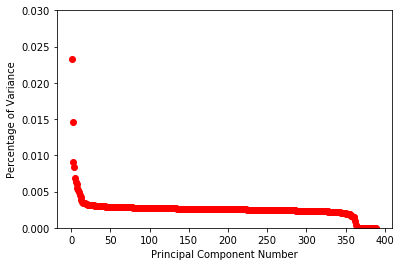

In [23]:
#Visual Exploration of Training Set

plt.scatter(feature_no,components_variance_PCA,color='red')
plt.xlabel('Principal Component Number')
plt.ylabel('Percentage of Variance')
plt.ylim(0,0.03)
plt.show()

The results of principal component analysis show that only two variables explain more than 1% of the variance. If we were to reduce the number of components to 336, we would account for 95% of the variance in the features.

In [17]:
#Applying PCA
from sklearn.decomposition import PCA
pcaObj = PCA(n_components=336)
X_PCA_reduced = pcaObj.fit_transform(X_std)

In [18]:
#K-fold Cross Validation on PCA set using Logistic Regression
from sklearn.model_selection import cross_val_score
modelAccuracies_logreg_PCA = cross_val_score(estimator=logRegObj, X=X_PCA_reduced, y=y2, cv=10)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [19]:
print("Logistic regression post-PCA")
print("Number of components")
print("336")
print("Model Accuracy mean")
print(modelAccuracies_logreg_PCA.mean())
print("Model Accuracy SD")
print(modelAccuracies_logreg_PCA.std())

Logistic regression post-PCA
Number of components
336
Model Accuracy mean
0.8197172681539808
Model Accuracy SD
0.05879634928921386


In [20]:
#Applying LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
ldaObj = LDA(n_components=None)
X_LDA= ldaObj.fit_transform(X_std, y2)
components_variance_LDA = ldaObj.explained_variance_ratio_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Linear Discriminant Analysis should not be used on this dataset because the variables are collinear.